# 12강과제

In [4]:
!pip install sktime

데이터 불러오기

In [5]:
!pip install pandas

In [6]:
import pandas as pd

# CSV 파일 읽기
ts = pd.read_csv('../장성욱/수진월별_수술현황_의료급여__20250706063637.csv', header=1)
   
    

# 데이터 프레임 정보 출력
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시점      216 non-null    int64 
 1   월별(1)   216 non-null    object
 2   계       216 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.2+ KB


In [7]:
#데이터프레임의 첫 5행 출력
ts.head()

,시점,월별(1),계
0,2006,1월,5332
1,2006,2월,5714
2,2006,3월,6442
3,2006,4월,5928
4,2006,5월,6250


# 시계열 데이터로  변환하기

In [8]:
# 시계열로 변환하기위해 인덱스를 설정
ts.index = pd.date_range(start="2006-01-01", periods=len(ts), freq="ME")

# 시계열 데이터 확인
ts.head()

,시점,월별(1),계
2006-01-31,2006,1월,5332
2006-02-28,2006,2월,5714
2006-03-31,2006,3월,6442
2006-04-30,2006,4월,5928
2006-05-31,2006,5월,6250


In [9]:
#시점, 월별(1) 열을 삭제

ts.drop(columns=["시점", "월별(1)"],inplace=True)

# 컬럼명 변경
ts.columns = ["수술건수"]

#시계열 데이터 확인
ts.head()

,수술건수
2006-01-31,5332
2006-02-28,5714
2006-03-31,6442
2006-04-30,5928
2006-05-31,6250


In [10]:
!pip install koreanize_matplotlib

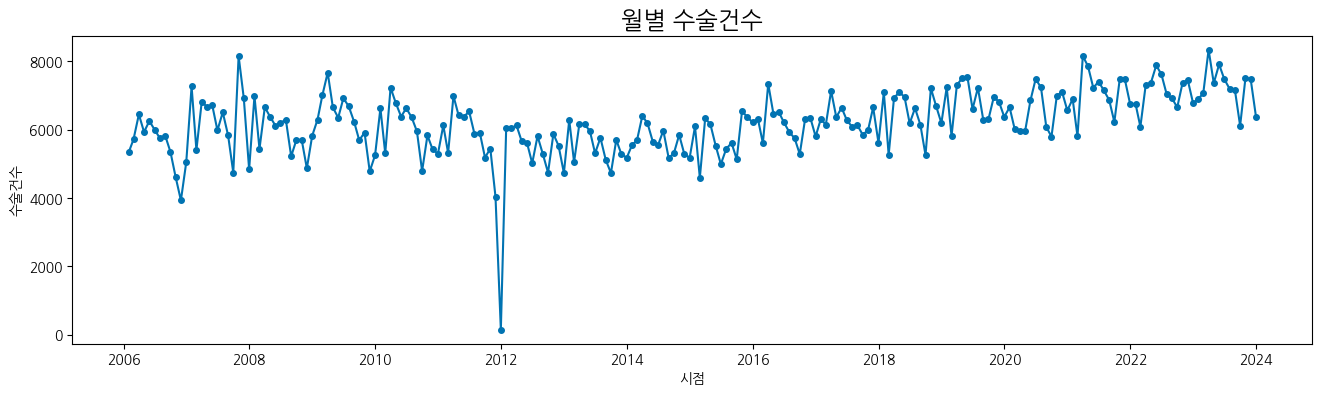

In [11]:
import koreanize_matplotlib
from sktime.utils.plotting import plot_series

#시계열 데이터 시각화
plot_series(ts, title="월별 수술건수", y_label="수술건수", x_label="시점");

In [12]:
!pip install seaborn


#Train Data: 180 , #Test Data: 36
--------------------------------------------------------------------------------


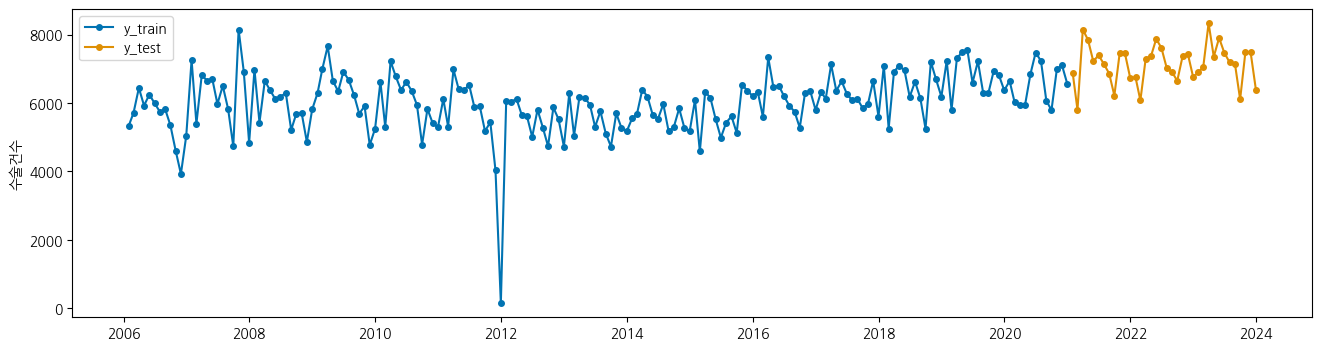

In [13]:
# 시계열 데이터세트를 train, test로 나누는 함수
from sktime.forecasting.model_selection import temporal_train_test_split

# 36개월을 test 데이터세트로 사용하고 나머지를 train 데이터세트로 사용
y_train, y_test = temporal_train_test_split(ts,test_size=36)

#데이터 세트 개수 확인
print('#Train Data:', y_train.shape[0], ', #Test Data:', y_test.shape[0])
print('-'*80) # 구분선

#시각화
plot_series(y_train,y_test,labels=["y_train", "y_test"]);

# 예측시평 설정

In [14]:
from sktime.forecasting.base import ForecastingHorizon # 시평 설정함수

#절대적 시평 설정
fh = ForecastingHorizon(y_test.index, is_relative=False)

#시평 설정 확ㅇ니
fh

ForecastingHorizon(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='ME', is_relative=False)

# 이상치 설정

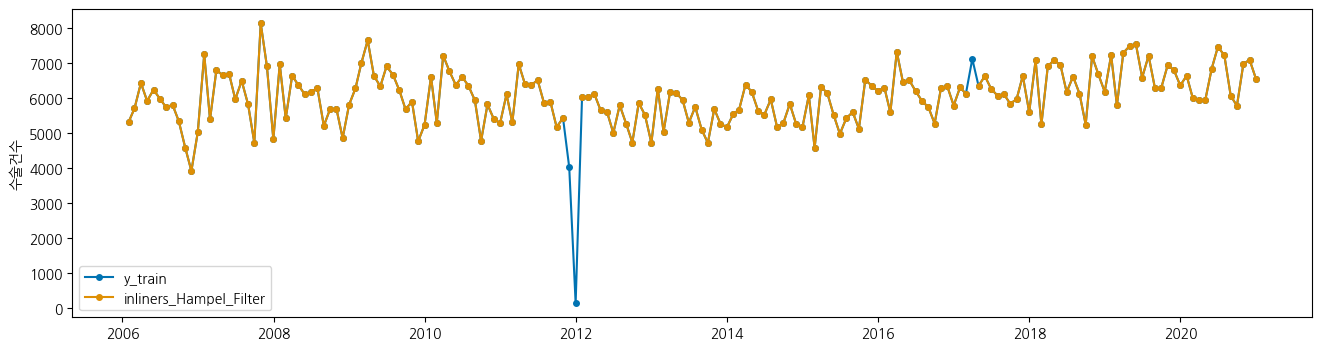

In [15]:
# HampelFilter 클래스 임포트
from sktime.transformations.series.outlier_detection import HampelFilter

#Hampel Filter 객체 생성, n_sigma는 outlier로 판단할 표준편차의 배수
transformer = HampelFilter(window_length=12,n_sigma=3)

# Hampel Filter를 이용하여 이상치 탐지 및 결측치롤 대체
y_clean = transformer.fit_transform(y_train)

# 시계열 데이터 시각화
plot_series(
    y_train,y_clean,
    labels=["y_train", "inliners_Hampel_Filter"]
    );

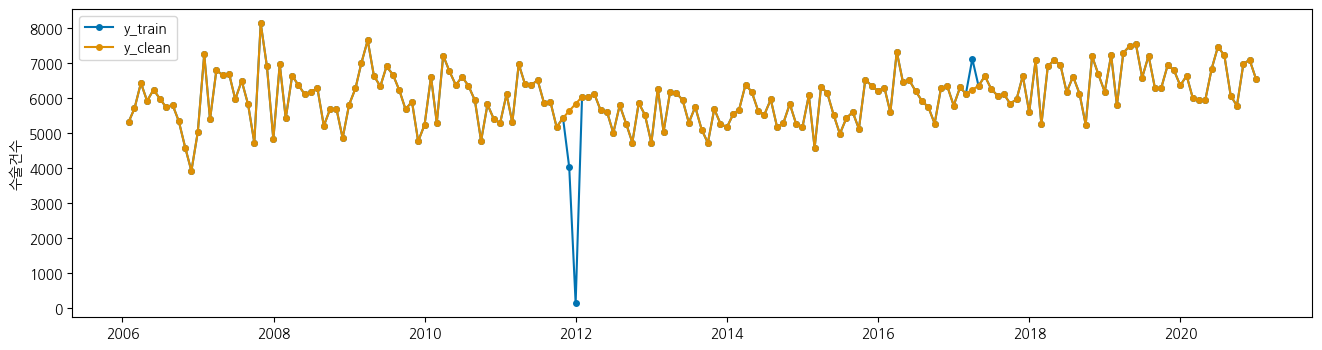

In [16]:
# 선형보간법을 이용한 이상치 대체
# 결측치를 선형보간으로 대체
y_clean = y_clean.interpolate(method='linear', limit_direction='both')

# 시계열 데이터 시각화
plot_series(
    y_train,y_clean,
    labels=["y_train", "y_clean"]
    );

# 시계열 정상성 검정
AugMented Dicky_Fuller test(단위근 검정)

In [17]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정(검정통계량, p-value, 사용된 시차의 수, 데이터의 수, 기각역의 값)
p_value = adfuller(y_clean, autolag="AIC")[1]

# 검정결과 출력
if p_value < 0.05:
    print(f'{p_value = :.4f}: 정상성 시계열')
else:
    print(f'{p_value = :.4f}: 비정상성 시계열')

p_value = 0.4804: 비정상성 시계열


In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung_Box 검정
p_value = acorr_ljungbox(y_clean, lags=1)['lb_pvalue'].iloc[0]

# 검정결과 출력
if p_value < 0.05:
    print(f'{p_value = :.4f}: 백색잡을 아님')
else:
    print(f'{p_value = :.4f}: 백색잡을')

p_value = 0.0000: 백색잡을 아님


# ARIMA 수행
예측모형 성능평가함수 정의

In [19]:
from sktime.performance_metrics.forecasting import mean_absolute_error as MAE #MAE 계산 함수
from sktime.performance_metrics.forecasting import mean_squared_error as MSE #MSE 계산 함수
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as MAPE # MAPE 계산 함수

# 성능 평가 함수
def evaluate(y_test, y_pred):
    mae = MAE(y_test, y_pred) #MAE 게산
    mse = MSE(y_test, y_pred) #MSE 게산
    mape = MAPE(y_test, y_pred) #MAPE 게산
    return mae,mse,mape

# 결과 저장을 위한 데이터 프레임 생성
results = pd.DataFrame(
    columns=["MAE", "MSE", "MAPE"] #성능 지표
    )


In [20]:
results

,MAE,MSE,MAPE


ARIMA 모형 차수 결정

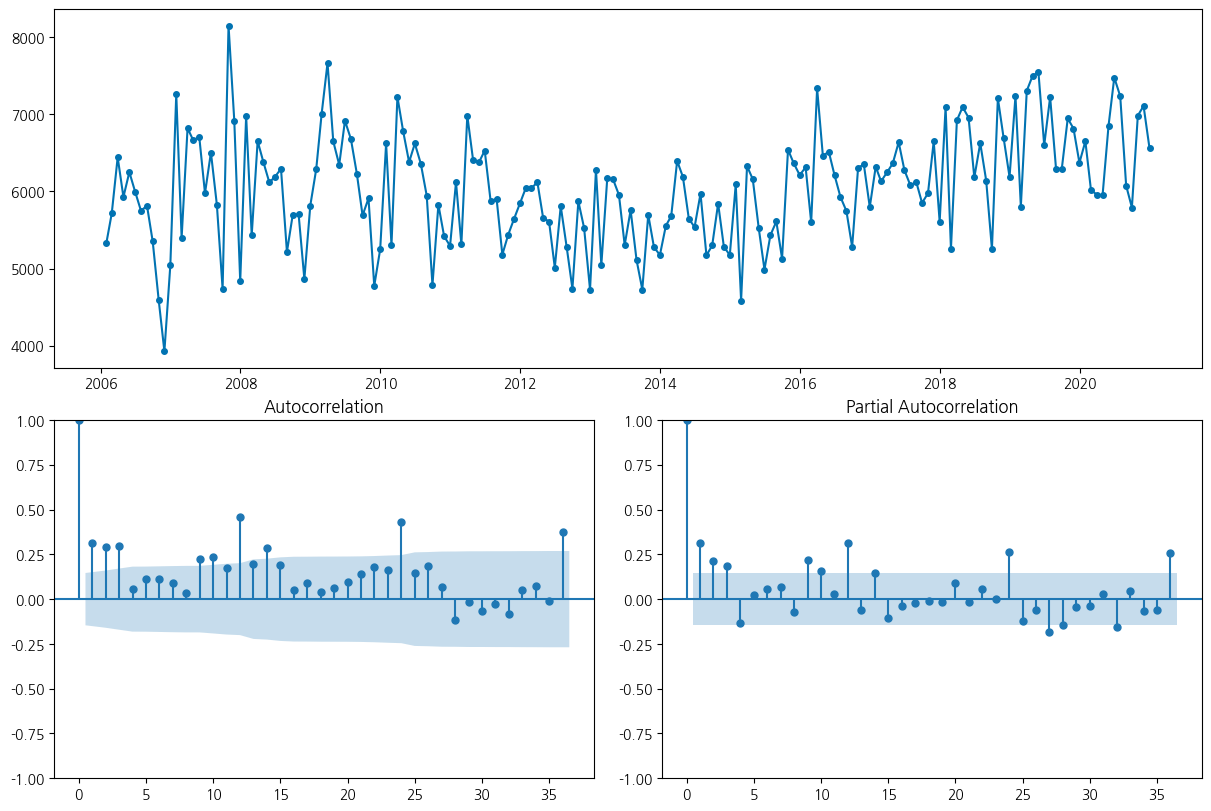

In [21]:
from sktime.utils.plotting import plot_correlations

#ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function) 시각화
fig, ax = plot_correlations(y_clean, lags=36)

ADF 검정 결과 비정상 시계열이므로 차분을 적용한 후 ACF와 PACF를 확인

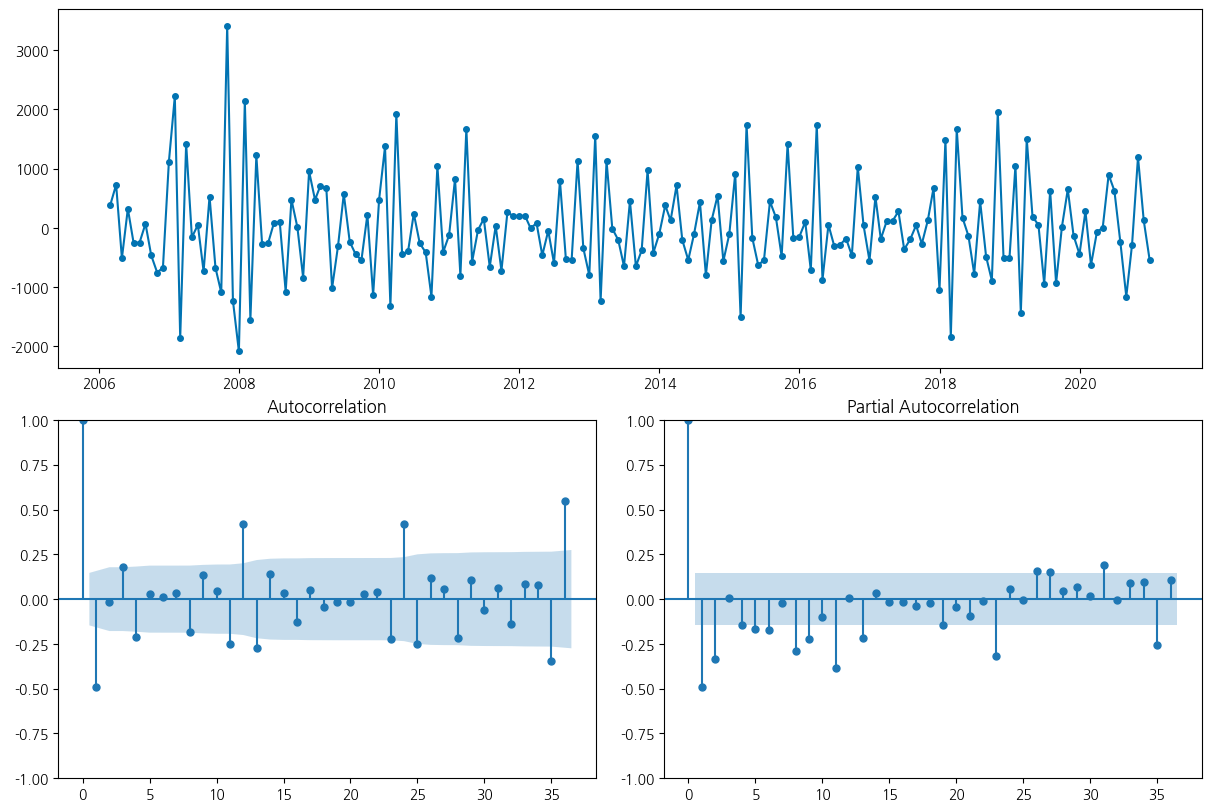

In [22]:
#1차 차분 시계열 데이터 생성
y_clean_d1 = y_clean.diff(1).dropna()

#ACF와 PACF 그래프 그리기
fig, ax = plot_correlations(y_clean_d1, lags=36)

In [23]:
!pip install pmdarima

In [24]:
!pip install numpy==1.26.0 
#numpy 버전 맟춤

In [25]:
from sktime.forecasting.arima import ARIMA

#ARIMA 모델의 차수 설정
pdq = (2,1,1)
#ARIMA 모델 객체 생성
arima = ARIMA(order=pdq)
#ARIMA 모델 훈련
arima.fit(y_clean)

#AutoARIMA 모델 요약 정보 출력
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  180
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1427.234
Date:                Sun, 06 Jul 2025   AIC                           2864.468
Time:                        09:09:04   BIC                           2880.405
Sample:                    01-31-2006   HQIC                          2870.931
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.3785     62.107      0.135      0.893    -113.348     130.105
ar.L1         -0.7209      0.238     -3.027      0.002      -1.188      -0.254
ar.L2         -0.3506      0.132     -2.666      0.0

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427954,0.070071


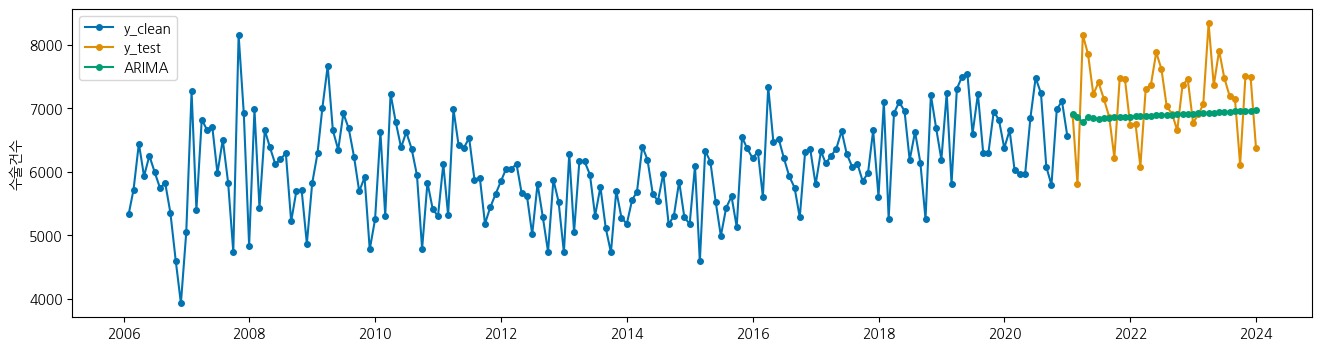

In [26]:
#예측
arima_pred = arima.predict(fh) # ARIMA 예측치

#예측치 시각화
fig = plot_series(y_clean, y_test, arima_pred, labels=["y_clean", "y_test", "ARIMA"])

#성능 평가
results.loc["ARIMA"+str(pdq)] = evaluate(y_test, arima_pred) #ARIMA 성능 평가
display(results) # 성능 평가 결과 출력

# SARIMA 수행

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1294.247
Date:                            Sun, 06 Jul 2025   AIC                           2602.494
Time:                                    09:17:36   BIC                           2624.320
Sample:                                01-31-2006   HQIC                          2611.353
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1435      2.507      0.057      0.954      -4.770       5.057
ar.L1          0.1909      0.091   

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427954,0.070071
"SARIMA(2, 1, 1)",318.021614,141142.936928,0.044373


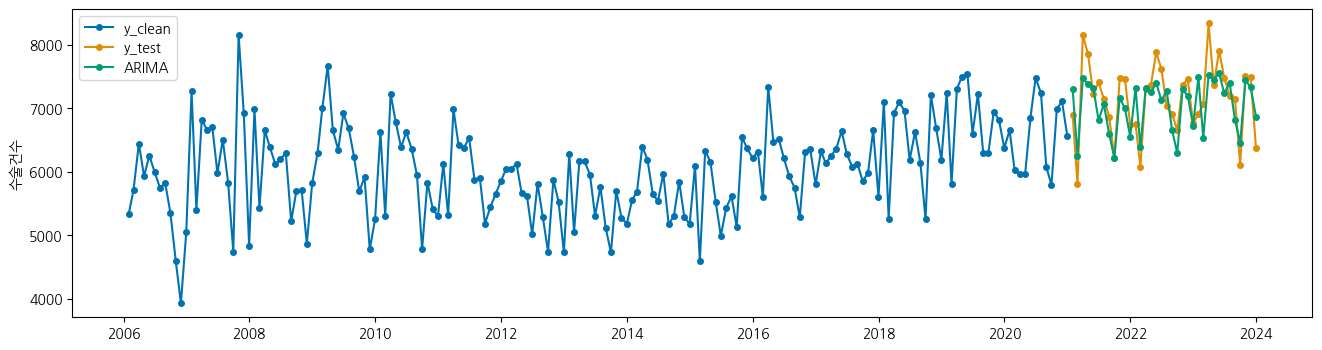

In [27]:
from sktime.forecasting.arima import ARIMA

#ARIMA 모델의 차수 설정
sarima = ARIMA(order=(2,1,1), seasonal_order=(1,1,1,12))

#ARIMA 모델 훈련
sarima.fit(y_clean)
print(sarima.summary()) #AutoARIMA 모델 요약 정보 출력

#예측
sarima_pred = sarima.predict(fh) # ARIMA 예측치

#예측치 시각화
fig = plot_series(y_clean, y_test, sarima_pred, labels=["y_clean", "y_test", "ARIMA"])

#성능 평가
results.loc["SARIMA"+str(pdq)] = evaluate(y_test, sarima_pred) #ARIMA 성능 평가
display(results) # 성능 평가 결과 출력

# AutoARIMA

In [28]:
from sktime.forecasting.arima import AutoARIMA

#ARIMA 모델의 차수 설정
auto_arima = AutoARIMA(max_p=3,max_q=3,sp=12,suppress_warnings=True)

#ARIMA 모델 훈련
auto_arima.fit(y_clean)
#AutoARIMA 모델 요약 정보 출력
print(auto_arima.summary()) 


c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1379.721
Date:                            Sun, 06 Jul 2025   AIC                           2773.441
Time:                                    09:21:16   BIC                           2795.753
Sample:                                01-31-2006   HQIC                          2782.488
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5663      0.187     -3.031      0.002      -0.933      -0.200
ma.L1         -0.0965      0.172   

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",505.579521,389370.427954,0.070071
"SARIMA(2, 1, 1)",318.021614,141142.936928,0.044373
AutoARIMA,329.360675,157287.700450,0.045727


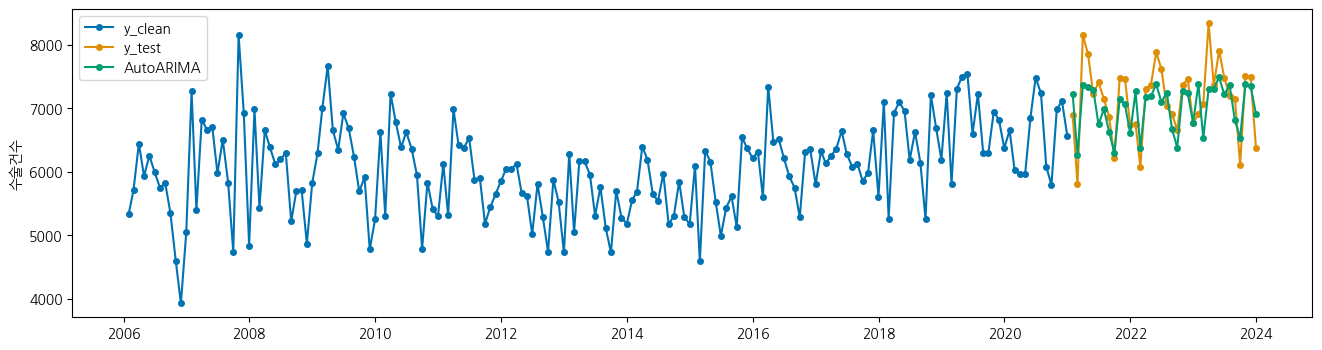

In [30]:
# AutoARIMA 예측치
auto_arima_pred = auto_arima.predict(fh)

# 예측치 시각화
fig = plot_series(y_clean, y_test, auto_arima_pred, labels=["y_clean", "y_test", "AutoARIMA"])

#성능 평가
results.loc["AutoARIMA"] = evaluate(y_test,auto_arima_pred) #AutoARIMA 성능 평가
display(results) # 성능 평가 결과 출력ㄷ

# 연습

In [31]:
!pip install sktime

In [32]:
#데이터 불러오기
!pip install pandas

In [49]:
import pandas as pd

# CSV 파일 읽기 (행정데이터 읽기위해 enconding='cp949'추가)
ts = pd.read_csv('../장성욱/월별_신고접수_20250706095359.csv', header=1, encoding='cp949')

   
    
# 데이터 프레임 정보 출력
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2018    71 non-null     int64 
 1   1월      71 non-null     object
 2   276     71 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ KB


In [50]:
#데이터프레임의 첫 5행 출력
ts.head()

,2018,1월,276
0,2018,2월,211
1,2018,3월,347
2,2018,4월,385
3,2018,5월,343
4,2018,6월,281


시계열데이터 변환

In [51]:
# 시계열로 변환하기위해 인덱스를 설정
ts.index = pd.date_range(start="2018-01", periods=len(ts), freq="ME")

# 시계열 데이터 확인
ts.head()

,2018,1월,276
2018-01-31,2018,2월,211
2018-02-28,2018,3월,347
2018-03-31,2018,4월,385
2018-04-30,2018,5월,343
2018-05-31,2018,6월,281


In [53]:
#시점, 월별(1) 열을 삭제

ts.drop(columns=["2018", "1월"],inplace=True)

# 컬럼명 변경
ts.columns = ["신고수"]

#시계열 데이터 확인
ts.head()

,신고수
2018-01-31,211
2018-02-28,347
2018-03-31,385
2018-04-30,343
2018-05-31,281


In [41]:
!pip install koreanize_matplotlib

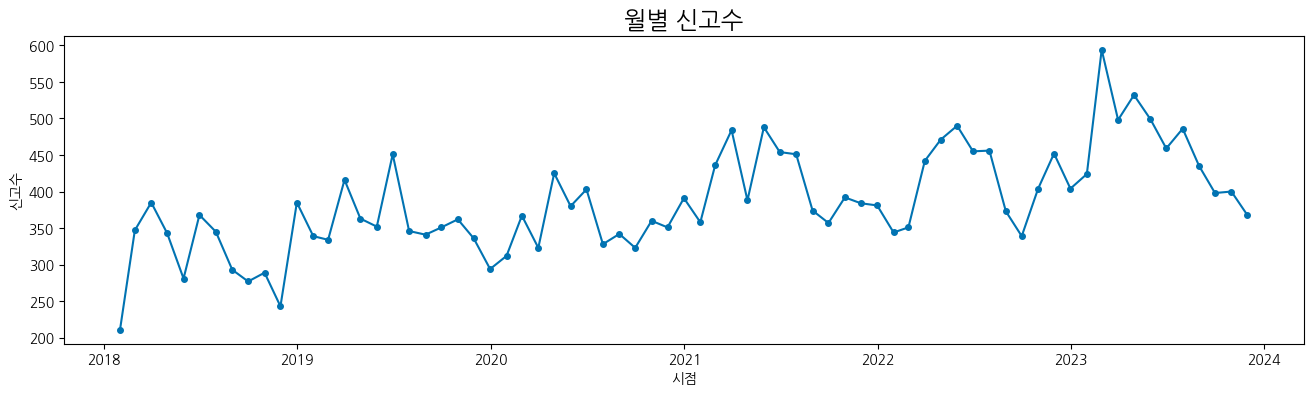

In [54]:
import koreanize_matplotlib
from sktime.utils.plotting import plot_series

#시계열 데이터 시각화
plot_series(ts, title="월별 신고수", y_label="신고수", x_label="시점");

#Train Data: 35 , #Test Data: 36
--------------------------------------------------------------------------------


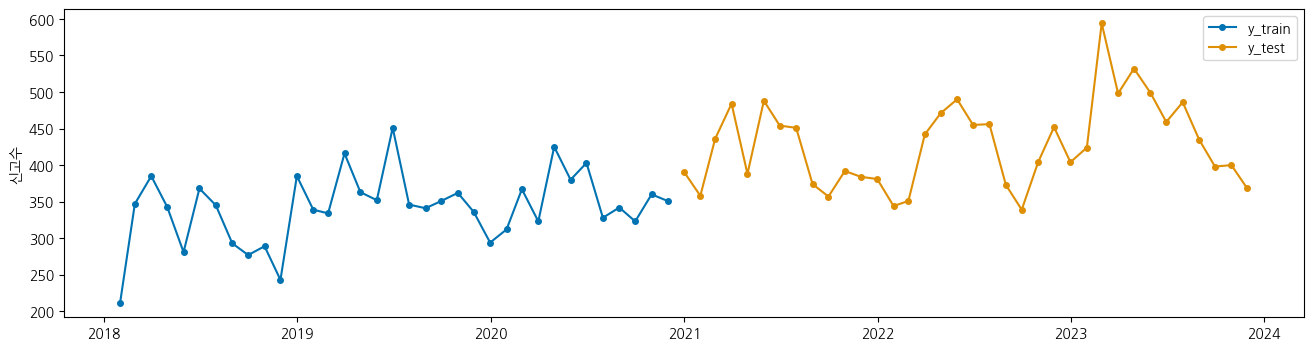

In [55]:
# 시계열 데이터세트를 train, test로 나누는 함수
from sktime.forecasting.model_selection import temporal_train_test_split

# 36개월을 test 데이터세트로 사용하고 나머지를 train 데이터세트로 사용
y_train, y_test = temporal_train_test_split(ts,test_size=36)

#데이터 세트 개수 확인
print('#Train Data:', y_train.shape[0], ', #Test Data:', y_test.shape[0])
print('-'*80) # 구분선

#시각화
plot_series(y_train,y_test,labels=["y_train", "y_test"]);

예측시평 설정

In [56]:
from sktime.forecasting.base import ForecastingHorizon # 시평 설정함수

#절대적 시평 설정
fh = ForecastingHorizon(y_test.index, is_relative=False)

#시평 설정 확ㅇ니
fh

ForecastingHorizon(['2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', freq='ME', is_relative=False)

이상치 설정

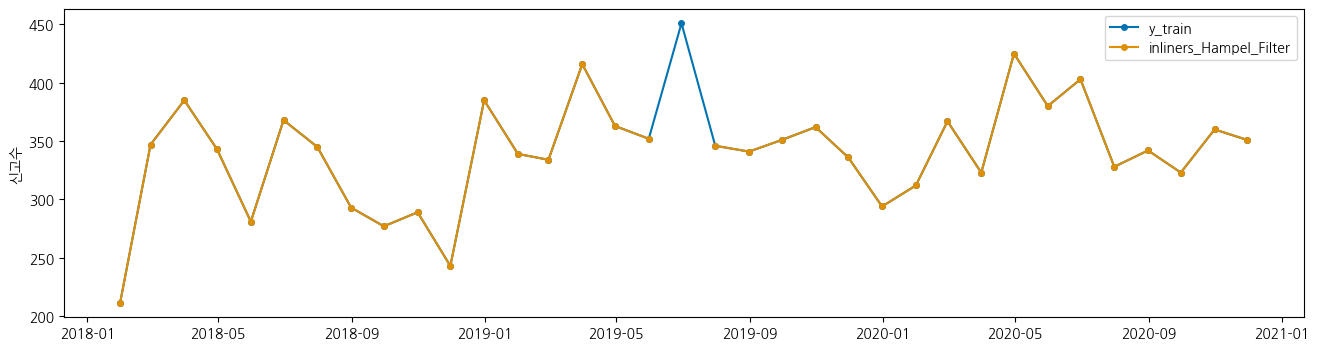

In [57]:
# HampelFilter 클래스 임포트
from sktime.transformations.series.outlier_detection import HampelFilter

#Hampel Filter 객체 생성, n_sigma는 outlier로 판단할 표준편차의 배수
transformer = HampelFilter(window_length=12,n_sigma=3)

# Hampel Filter를 이용하여 이상치 탐지 및 결측치롤 대체
y_clean = transformer.fit_transform(y_train)

# 시계열 데이터 시각화
plot_series(
    y_train,y_clean,
    labels=["y_train", "inliners_Hampel_Filter"]
    );

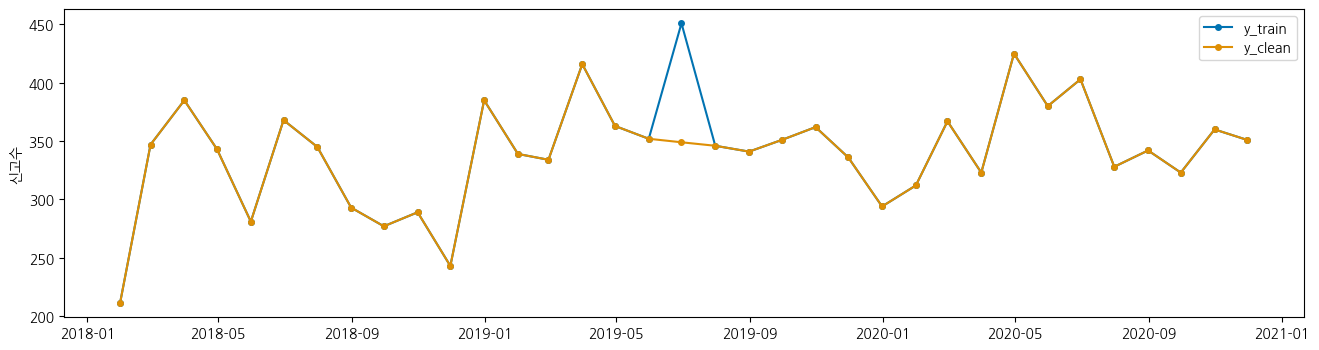

In [58]:
# 선형보간법을 이용한 이상치 대체
# 결측치를 선형보간으로 대체
y_clean = y_clean.interpolate(method='linear', limit_direction='both')

# 시계열 데이터 시각화
plot_series(
    y_train,y_clean,
    labels=["y_train", "y_clean"]
    );

# 시계열 정상성 검정
AugMented Dicky_Fuller test(단위근 검정)

In [59]:
from statsmodels.tsa.stattools import adfuller

# ADF 검정(검정통계량, p-value, 사용된 시차의 수, 데이터의 수, 기각역의 값)
p_value = adfuller(y_clean, autolag="AIC")[1]

# 검정결과 출력
if p_value < 0.05:
    print(f'{p_value = :.4f}: 정상성 시계열')
else:
    print(f'{p_value = :.4f}: 비정상성 시계열')

p_value = 0.0000: 정상성 시계열


In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung_Box 검정
p_value = acorr_ljungbox(y_clean, lags=1)['lb_pvalue'].iloc[0]

# 검정결과 출력
if p_value < 0.05:
    print(f'{p_value = :.4f}: 백색잡을 아님')
else:
    print(f'{p_value = :.4f}: 백색잡을')

p_value = 0.3589: 백색잡을


ARIMA 수행

In [61]:
from sktime.performance_metrics.forecasting import mean_absolute_error as MAE #MAE 계산 함수
from sktime.performance_metrics.forecasting import mean_squared_error as MSE #MSE 계산 함수
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as MAPE # MAPE 계산 함수

# 성능 평가 함수
def evaluate(y_test, y_pred):
    mae = MAE(y_test, y_pred) #MAE 게산
    mse = MSE(y_test, y_pred) #MSE 게산
    mape = MAPE(y_test, y_pred) #MAPE 게산
    return mae,mse,mape

# 결과 저장을 위한 데이터 프레임 생성
results = pd.DataFrame(
    columns=["MAE", "MSE", "MAPE"] #성능 지표
    )


In [62]:
results

,MAE,MSE,MAPE


ARIMA 모형 차수 검정

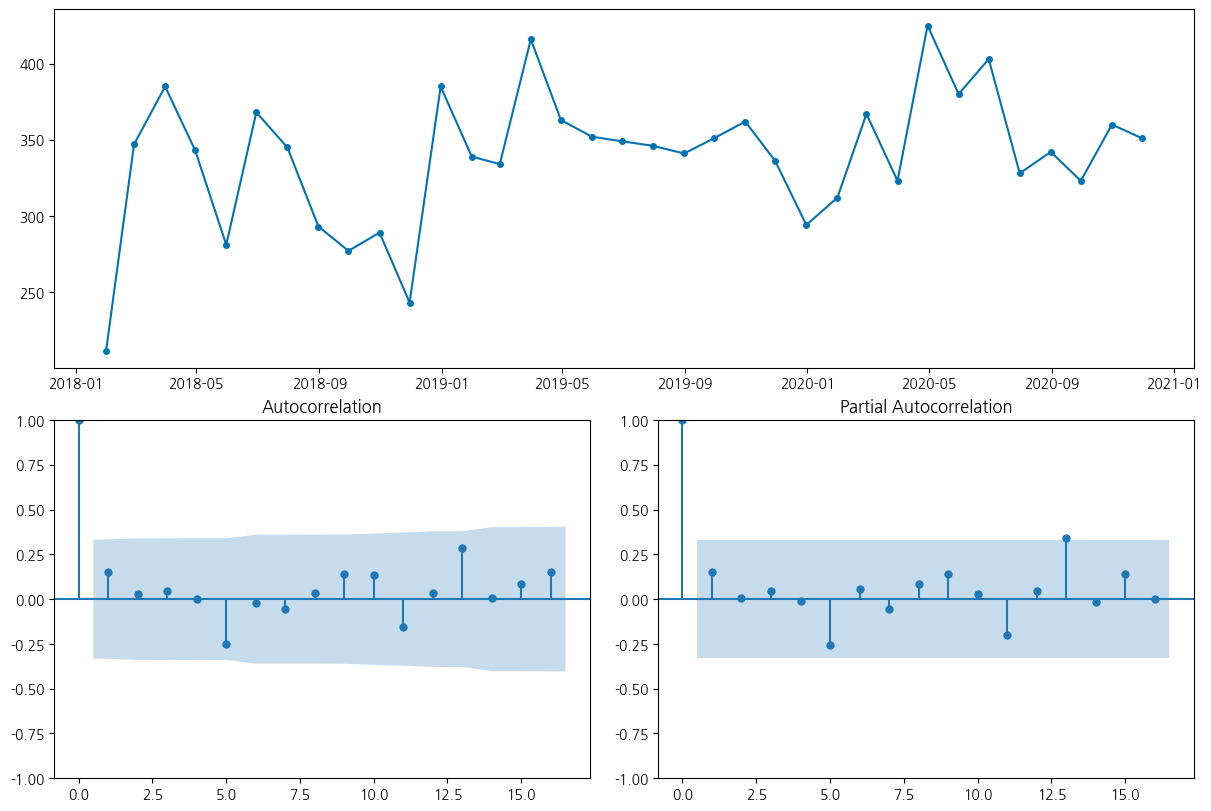

In [ ]:
from sktime.utils.plotting import plot_correlations

#ACF(Autocorrelation Function)과 PACF(Partial Autocorrelation Function) 시각화 길이에 맞게 16으로 lags 조절
fig, ax = plot_correlations(y_clean, lags=16)

ADF 검정 결과 비정상 시계열이므로 차분을 적용한 후 ACF와 PACF를 확인

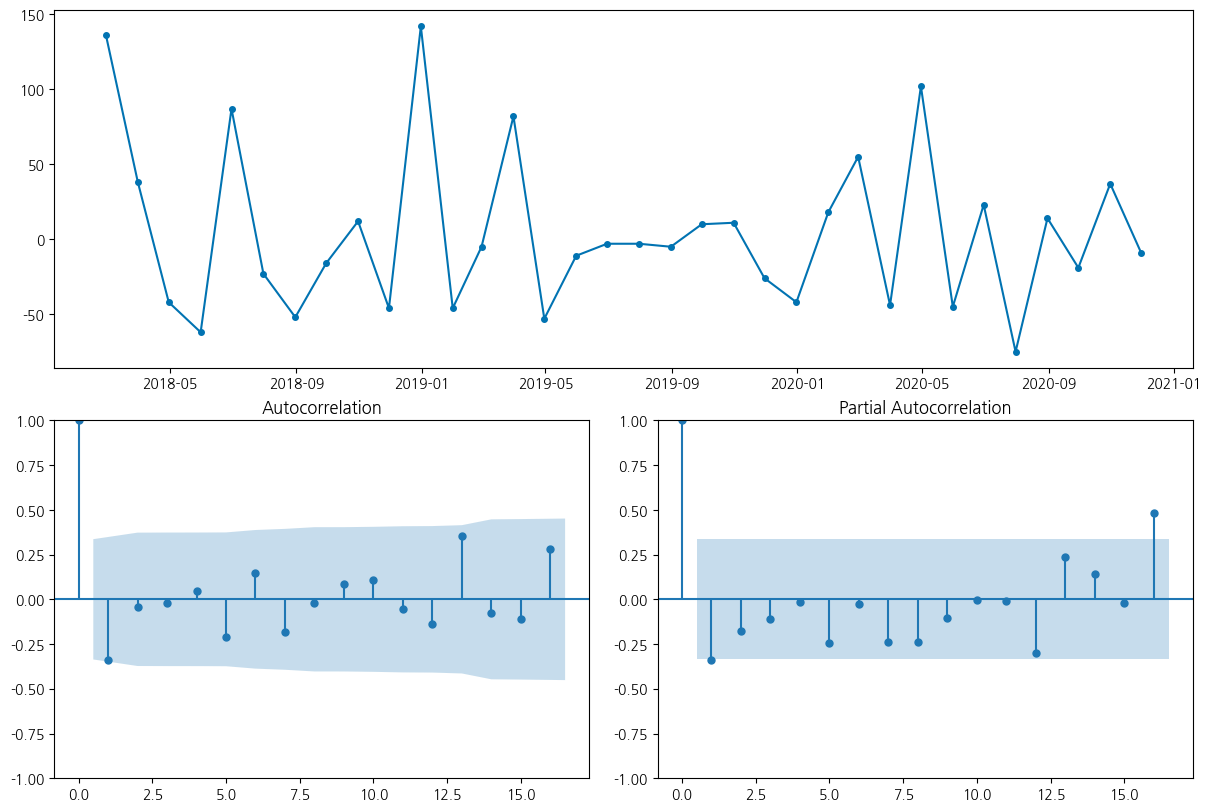

In [70]:
#1차 차분 시계열 데이터 생성
y_clean_d1 = y_clean.diff(1).dropna()

#ACF와 PACF 그래프 그리기
fig, ax = plot_correlations(y_clean_d1, lags=16)

In [71]:
!pip install pmdarima

In [72]:
from sktime.forecasting.arima import ARIMA

#ARIMA 모델의 차수 설정
pdq = (2,1,1)
#ARIMA 모델 객체 생성
arima = ARIMA(order=pdq)
#ARIMA 모델 훈련
arima.fit(y_clean)

#AutoARIMA 모델 요약 정보 출력
print(arima.summary())

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -176.934
Date:                Sun, 06 Jul 2025   AIC                            363.868
Time:                        10:02:03   BIC                            371.500
Sample:                    01-31-2018   HQIC                           366.471
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3535      0.992      1.364      0.173      -0.592       3.298
ar.L1          0.1569      0.247      0.634      0.526      -0.328       0.641
ar.L2         -0.0438      0.225     -0.195      0.8

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",51.491814,4404.124742,0.112442


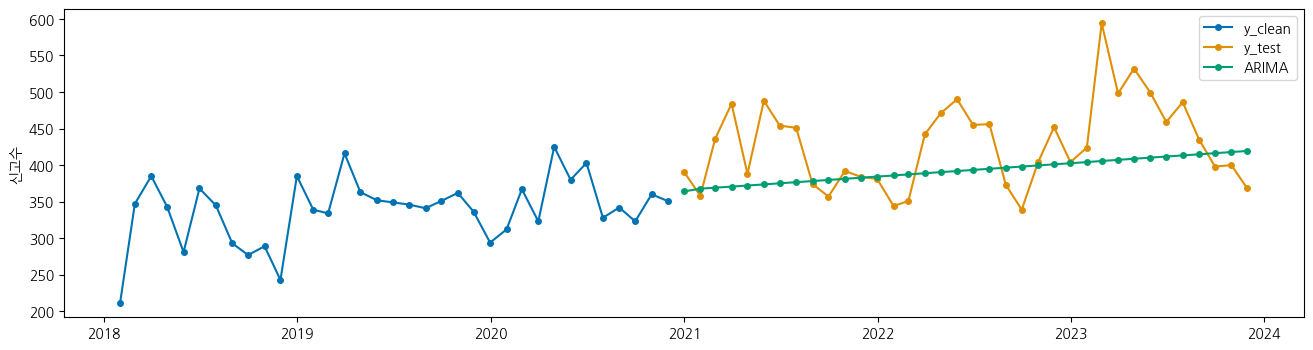

In [73]:
#예측
arima_pred = arima.predict(fh) # ARIMA 예측치

#예측치 시각화
fig = plot_series(y_clean, y_test, arima_pred, labels=["y_clean", "y_test", "ARIMA"])

#성능 평가
results.loc["ARIMA"+str(pdq)] = evaluate(y_test, arima_pred) #ARIMA 성능 평가
display(results) # 성능 평가 결과 출력

SARIMA 수행

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -118.673
Date:                            Sun, 06 Jul 2025   AIC                            251.347
Time:                                    10:02:50   BIC                            258.984
Sample:                                01-31-2018   HQIC                           253.146
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.3039      3.883     -0.336      0.737      -8.914       6.306
ar.L1         -0.0174      0.381   

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",51.491814,4404.124742,0.112442
"SARIMA(2, 1, 1)",67.529225,6729.866331,0.148555


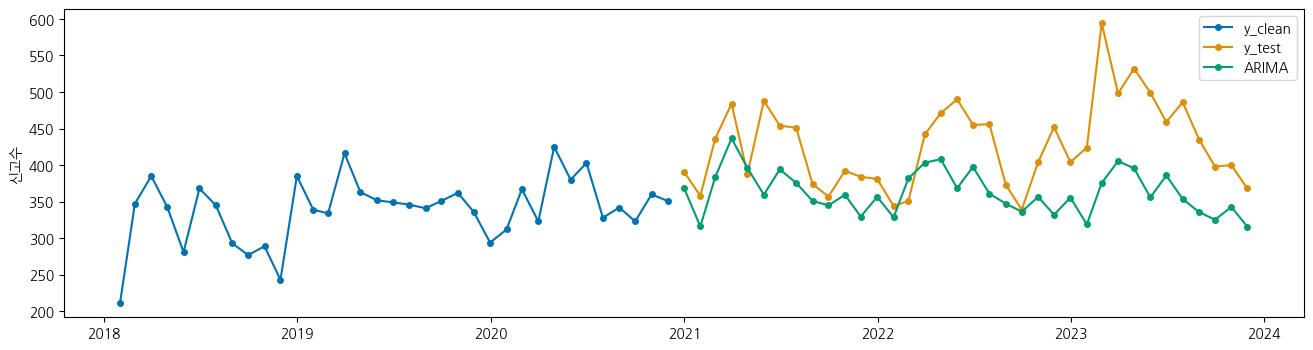

In [74]:
from sktime.forecasting.arima import ARIMA

#ARIMA 모델의 차수 설정
sarima = ARIMA(order=(2,1,1), seasonal_order=(1,1,1,12))

#ARIMA 모델 훈련
sarima.fit(y_clean)
print(sarima.summary()) #AutoARIMA 모델 요약 정보 출력

#예측
sarima_pred = sarima.predict(fh) # ARIMA 예측치

#예측치 시각화
fig = plot_series(y_clean, y_test, sarima_pred, labels=["y_clean", "y_test", "ARIMA"])

#성능 평가
results.loc["SARIMA"+str(pdq)] = evaluate(y_test, sarima_pred) #ARIMA 성능 평가
display(results) # 성능 평가 결과 출력

AutoARIMA

In [75]:
from sktime.forecasting.arima import AutoARIMA

#ARIMA 모델의 차수 설정
auto_arima = AutoARIMA(max_p=3,max_q=3,sp=12,suppress_warnings=True)

#ARIMA 모델 훈련
auto_arima.fit(y_clean)
#AutoARIMA 모델 요약 정보 출력
print(auto_arima.summary()) 


c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                        SARIMAX   Log Likelihood                -182.193
Date:                Sun, 06 Jul 2025   AIC                            368.386
Time:                        10:03:14   BIC                            371.497
Sample:                    01-31-2018   HQIC                           369.460
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    338.9714      8.136     41.664      0.000     323.025     354.918
sigma2      1945.2849    422.077      4.609      0.000    1118.028    2772.541
Ljung-Box (L1) (Q):                   0.84   Jarque-

c:\Users\USER\miniforge3\envs\stat\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,MAE,MSE,MAPE
"ARIMA(2, 1, 1)",51.491814,4404.124742,0.112442
"SARIMA(2, 1, 1)",67.529225,6729.866331,0.148555
AutoARIMA,89.139683,11288.092880,0.194214


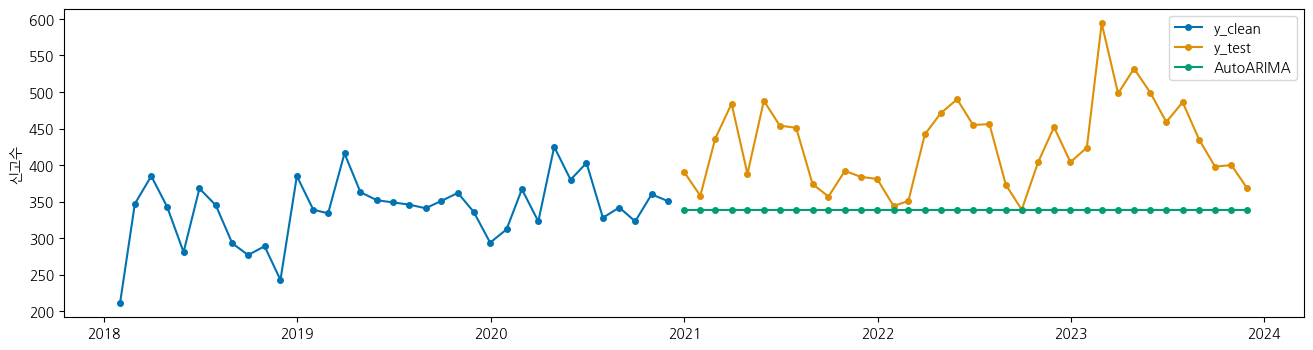

In [76]:
# AutoARIMA 예측치
auto_arima_pred = auto_arima.predict(fh)

# 예측치 시각화
fig = plot_series(y_clean, y_test, auto_arima_pred, labels=["y_clean", "y_test", "AutoARIMA"])

#성능 평가
results.loc["AutoARIMA"] = evaluate(y_test,auto_arima_pred) #AutoARIMA 성능 평가
display(results) # 성능 평가 결과 출력ㄷ